# Results of the 4750 m a.s.l: ENSO influence

In [1]:
%pylab inline
import os
import downglacier.sandbox.tcd_utils as utils
import downglacier.graphics as dgplot
import seaborn as sns
import pandas as pd
from datetime import datetime as dt
pal = sns.color_palette('pastel')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.2)
monthstr = np.array(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

Populating the interactive namespace from numpy and matplotlib


In [2]:
lag=3

In [3]:
wd = utils.run_standard(run=False)
odir = os.path.join(wd, 'output')

In [4]:
dfd = pd.read_csv(os.path.join(odir, 'diagnostics', 'predict_ts.csv'), index_col=0, 
                               parse_dates= {"time" : [0]}).loc[dt(1979,10,1):dt(2013,9,1)]
dfi = pd.read_csv(os.path.join(odir, 'diagnostics', 'predict_info.csv'), index_col=0).T
# filter keys fir height
dfi.columns = [s.split('_')[0] + '_' + s.split('_')[2] for s in dfi.columns]
dfd.columns = [s.split('_')[0] + '_' + s.split('_')[2] for s in dfd.columns]
varkeys = dfd.columns
# Conventions for the plots below
dfd.loc[:, 'meltmassfromsum_diag'] = -dfd['meltmassfromsum_diag']
dfd.loc[:, 'submass_diag'] = -dfd['submass_diag']

## Error assessment

In [5]:
dfe = dfd * 0.
for varn in dfd.columns:
    err = dfi.loc['rmse', varn]
    if varn in ['mbtotfromsum_diag', 'mbtot_ds']: 
        err = (250 + err) / sqrt(2)
    dfe[varn].iloc[:] = err

## Monthly Mass-Balance - 1980--2013 (Fig 5)

In [6]:
bp = utils.get_sst_baseplot(lag=lag)

In [7]:
data = dfd['mbtotfromsum_diag'].values
err = dfe['mbtotfromsum_diag'].values

In [8]:
pc1 = np.where(dfd.index == '20051001')
pc2 = np.where(dfd.index == '20090901')

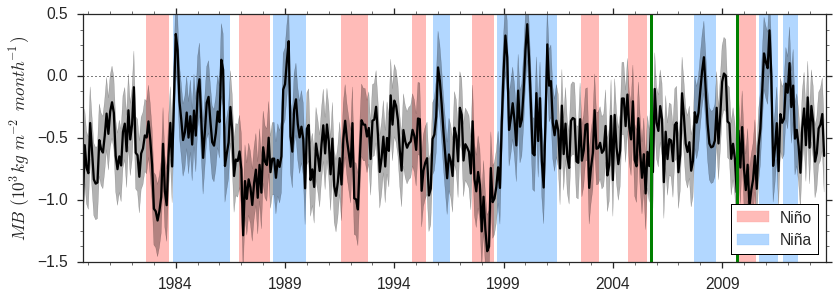

In [9]:
fig = plt.figure(figsize=(12, 4), dpi=200)
ax = fig.add_subplot(111)

ax.plot(bp['xtime'], data / 1000., color='black')
lims = ax.get_ylim()

ax.set_ylim(lims)
plt.xlim([0, bp['nx']])
import matplotlib.collections as collections
span_where = collections.BrokenBarHCollection.span_where
c = span_where(bp['tspans'], ymin=lims[0], ymax=lims[1], where=bp['isnino'], color=pal[2], alpha=0.7, linewidths=0)
ax.add_collection(c)
c = span_where(bp['tspans'], ymin=lims[0], ymax=lims[1], where=bp['isnina'], color=pal[0], alpha=0.7, linewidths=0)
ax.add_collection(c)

ax.fill_between(bp['xtime'], (data-err) / 1000., (data+err) / 1000., 
                color='k', 
                interpolate=True, alpha=0.3)

from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_ticks(bp['majorTickPos'])
ax.xaxis.set_ticks(bp['minorTickPos'], minor=True)
ax.set_xticklabels(bp['majorTickNames'])

plt.axhline(0., linewidth=1, color='k', linestyle =':')

plt.axvline(pc1, linewidth=3, color='green', linestyle ='-')
plt.axvline(pc2, linewidth=3, color='green', linestyle ='-')

plt.subplots_adjust(left=0.11, right=0.97, top=0.96, bottom=0.1)

import matplotlib.patches as mpatches
pat1 = mpatches.Patch(color=pal[2], alpha=0.7, label=u'Niño')
pat2 = mpatches.Patch(color=pal[0], alpha=0.7, label=u'Niña')
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = 'True'
legend = plt.legend(handles=[pat1,pat2], loc='lower right')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_linewidth(1)

ax.xaxis.grid(False)
ax.set_ylabel(u'$MB\, (10^{3} kg\, m^{-2}\, month^{-1})$')
plt.savefig(os.path.join(utils.get_plot_dir(), 'Fig_05.pdf'))

## Niño Niña Composites

This gets more complicated. We cary more dataframes, also for error progagation and testing significance. The error of the compites (over i) is computed as:

$ \sigma = \sqrt{ \frac{1}{n} \sum(\sigma_{i}^{2} + \mu_{i}^{2}) - \mu^{2}  } $ 

All this appears quite useless because no composite is significant, as we will see.

In [10]:
dfsst = utils.get_enso_df(lag=lag)

In [11]:
dfs = dfd**2 + dfe**2 # this will be needed later

In [12]:
dft = pd.concat([dfd, dfe, dfs, dfsst], axis=1, keys=['val', 'err', 'sqt', 'sst'])
dft.columns = [' '.join(col).strip() for col in dft.columns.values]

Composites:

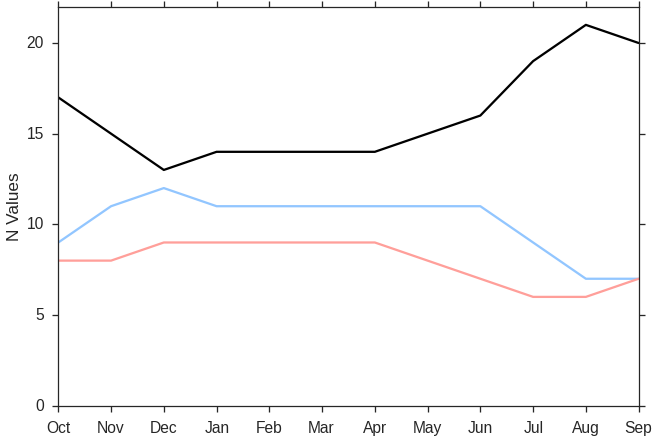

In [13]:
alldf = dft.groupby('sst mi').mean()

gps = dft.groupby('sst is_nino')
for i, g in gps:
    if not i: continue
    ninodf = g.groupby('sst mi').agg(['mean', 'count'])
gps = dft.groupby('sst is_nina')
for i, g in gps:
    if not i: continue
    ninadf = g.groupby('sst mi').agg(['mean', 'count'])
gps = dft.groupby('sst is_neutral')
for i, g in gps:
    if not i: continue
    neutdf = g.groupby('sst mi').agg(['mean', 'count'])

fig, ax = plt.subplots()
ax.plot(neutdf['val airtemp_ds']['count'], color='k', label='Neutral')
ax.plot(ninadf['val airtemp_ds']['count'], color=pal[0], label='Niño')
ax.plot(ninodf['val airtemp_ds']['count'], color=pal[2], label='Niña')
ax.set_ylabel('N Values')
ax.set_xticks(np.arange(12))
ax.set_xlim([0, 11])
ax.set_ylim([0, 22])
ax.set_xticklabels(monthstr, rotation=0);

In [14]:
# Compute the Error:
for varn in varkeys:
    for tdf in [ninodf, ninadf, neutdf]:
        tdf.loc[:, ('val ' + varn, 'err')] = np.sqrt(tdf['sqt ' + varn]['mean'] - tdf['val ' + varn]['mean']**2)

Clean useless things:

In [15]:
valnames = [('val ' + varn) for varn in varkeys]
ninodf = ninodf[valnames]
ninadf = ninadf[valnames]
neutdf = neutdf[valnames]

### Difference between composites and significance of that diff

In [16]:
diffdf = ninodf*0
for varn in varkeys:
    mu1 = ninodf['val ' + varn]['mean']
    mu2 = ninadf['val ' + varn]['mean']
    s1 = ninodf['val ' + varn]['err']
    s2 = ninadf['val ' + varn]['err']
    N1 = ninodf['val ' + varn]['count']
    N2 = ninadf['val ' + varn]['count']
    _, pv = utils.welch_t_test(mu1, s1, N1, mu2, s2, N2)
    diffdf.loc[:, ('val ' + varn, 'mean')] =  mu1 - mu2 
    diffdf.loc[:, ('val ' + varn, 'sig')] = pv

Is anything significant?

In [17]:
for varn in varkeys:
    if np.any(diffdf[('val ' + varn, 'sig')] < 0.05):
        print('Yes! {}: {}'.format(varn, ', '.join(monthstr[np.where(diffdf[('val ' + varn, 'sig')] < 0.05)])))
    if np.any(diffdf[('val ' + varn, 'sig')] < 0.1):
        print('Well... {}: {}'.format(varn, ', '.join(monthstr[np.where(diffdf[('val ' + varn, 'sig')] < 0.1)])))

Yes! airtemp_ds: Feb
Well... airtemp_ds: Jan, Feb, Mar
Well... mbtotfromcfnet_diag: Jan, Feb
Yes! mbtotfromcfsum_diag: Feb
Well... mbtotfromcfsum_diag: Jan, Feb
Well... mbtotfromnet_diag: Jan, Feb
Yes! meltmass_ds: Feb
Well... meltmass_ds: Jan, Feb
Well... meltmassfromnet_diag: Jan, Feb
Well... meltmassfromnetcf_diag: Jan, Feb
Well... meltmassfromsum_diag: Jan, Feb, Mar
Well... meltmassfromsumcf_diag: Jan, Feb
Well... prcpsolclip_diag: Feb
Yes! qm_ds: Feb
Well... qm_ds: Jan, Feb
Well... qmfromnet_diag: Jan, Feb
Yes! qmfromsum_diag: Feb
Well... qmfromsum_diag: Jan, Feb
Well... qps_ds: Feb
Well... subsurfmass_ds: Jan, Feb
Well... swnet_ds: Feb
Well... swnetsum_diag: Feb


### Plotting the average of the composites for fun:

In [18]:
pal = sns.color_palette('deep')

In [19]:
def plot_ninonina_composites(varn):
    
    longn = dfi.loc['long_name', varn]
    unit = dgplot.__parseunit(dfi.loc['unit', varn])

    alpha = 0.3
    
    fig = plt.figure(figsize=(10, 6), dpi=200)
    ax = fig.add_subplot(111)
    
    v = neutdf['val ' + varn]['mean']
    e = neutdf['val ' + varn]['err']
    ax.fill_between(v.index, v-e, v+e, color='k', interpolate=True, alpha=alpha)    
    v.plot(ax=ax, color='k', linewidth=2, label='Neutral')

    v = ninodf['val ' + varn]['mean']
    e = ninodf['val ' + varn]['err']
    ax.fill_between(v.index, v-e, v+e, color=pal[2], interpolate=True, alpha=alpha)    
    v.plot(ax=ax, color=pal[2], zorder=8, linewidth=3, label='Niño')
    
    v = ninadf['val ' + varn]['mean']
    e = ninadf['val ' + varn]['err']
    ax.fill_between(v.index, v-e, v+e, color=pal[0], interpolate=True, alpha=alpha)    
    v.plot(ax=ax, color=pal[0], zorder=8, linewidth=3, label='Niña')
    
    isig = np.where(diffdf['val ' + varn]['sig'] < 0.1)
    xpoints = np.arange(12) / 11.
    ypoints = np.repeat(0.03, 12)
    plt.plot(xpoints[isig], ypoints[isig], 'ko', transform=ax.transAxes, label='p < 0.1')
    
    pat3 = mpatches.Patch(color='k', alpha=0.5, label=' \n $\pm RMSE \, / \, \sqrt{N}$ \n (standard)')
    pat4 = mpatches.Patch(color='k', alpha=0.2, label=' \n $\pm RMSE$ \n (conservative) \n')

    plt.subplots_adjust(left=0.12, right=0.75, top=0.94, bottom=0.08)

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles= [handles[0]] + [handles[1]] + [handles[2]] + [pat3, pat4] + [handles[3]], 
               loc=(1.01,0.4), prop={'size':16}, frameon=False);

    ax.set_xlabel('')
    ax.set_ylabel(unit)
    ax.set_title(longn)
    ax.set_xticks(np.arange(12)+1)
    _ = ax.set_xticklabels(monthstr)

In [20]:
toplot = ['airtemp_ds', 'lwin_ds', 'lwnetsum_diag', 'lwout_ds', 'mbtotfromsum_diag', 
          'prcpsolclip_diag', 'prcptotclip_diag', 'qc_ds', 'ql_ds', 'qmfromsum_diag', 
          'qps_ds', 'qs_ds', 'meltmassfromsum_diag', 'submass_diag', 'subsurfmass_ds', 
          'swin_ds', 'swnetsum_diag', 'swout_ds']
# for i, vn in enumerate(toplot): plot_ninonina_composites(vn);

## Barplot (Fig 7)

In [21]:
diffm = []
for varn in varkeys:
    diffm.append(diffdf['val ' + varn]['mean'])
diffm = pd.concat(diffm, axis=1, keys=varkeys)

In [22]:
name = ['$SW_{Net}$', '$LW_{Net}$', '$Q_{L}$', '$Q_{S}$', '$Q_{PS}$', '$Q_{C}$']
keys = ['swnetsum_diag','lwnetsum_diag','ql_ds','qs_ds','qps_ds','qc_ds']
dfed = diffm[keys]
dfed.columns = name
dfea = alldf[['val ' + v for v in keys]]
dfea.columns = name

In [23]:
name = ['$M_{Melt}$', '$M_{Subli}$', '$M_{Subs}$', '$PRPC_{S}$']
keys = ['meltmassfromsum_diag','submass_diag','subsurfmass_ds','prcpsolclip_diag']
dfmd = diffm[keys]
dfmd.columns = name
dfma = alldf[['val ' + v for v in keys]]
dfma.columns = name

In [24]:
def plot_bar_budget(datal, datar, title, unit, ylim1=None, ylim2=None):
    
    fig = plt.figure(figsize=(14, 6), dpi=200)

    ax = fig.add_subplot(121)
    datal.plot(kind='bar', stacked=True, ax=ax, legend=False)
    plt.plot(datal.sum(axis=1), color='black', label='$Sum$')
    
    plt.text(0.02, 0.93, title + u': 1980-2014', transform=ax.transAxes, fontsize=22,
             bbox=dict(facecolor='white', edgecolor='k', pad=5.0))
    ax.set_xticklabels(monthstr, rotation=0)
    ax.set_xlabel('') 
    ax.set_ylabel(unit) 
    if ylim1 is not None:
        ax.set_ylim(ylim1)

    ax = fig.add_subplot(122)
    datar.plot(kind='bar', stacked=True, ax=ax)
    plt.plot(datar.sum(axis=1), color='black', label='$Sum$')

    plt.text(0.02, 0.93, title + u': diff Niño - Niña', transform=ax.transAxes, fontsize=22,
             bbox=dict(facecolor='white', edgecolor='k', pad=5.0))
    
    ax.set_xticklabels(monthstr, rotation=0)
    ax.set_xlabel('') 
    if ylim2 is not None:
        ax.set_ylim(ylim2)
        
    cnt = ninodf['val airtemp_ds']['count']
    for i, c in enumerate(cnt):
        cc = ax.transAxes.transform([(0., 0.06)])
        inv = ax.transData.inverted()
        cc = inv.transform(cc)
        ax.text(i, cc[0][1], c, horizontalalignment='center', size=12, color=pal[2])
        
    cnt = ninadf['val airtemp_ds']['count']
    for i, c in enumerate(cnt):
        cc = ax.transAxes.transform([(0., 0.015)])
        inv = ax.transData.inverted()
        cc = inv.transform(cc)
        ax.text(i, cc[0][1], c, horizontalalignment='center', size=12, color=pal[0])
    
    plt.subplots_adjust(left=0.08, right=0.87, top=0.94, bottom=0.07)
    plt.legend(bbox_to_anchor=(1.02, 1.), fontsize=18, loc=2, borderaxespad=0, frameon=False);

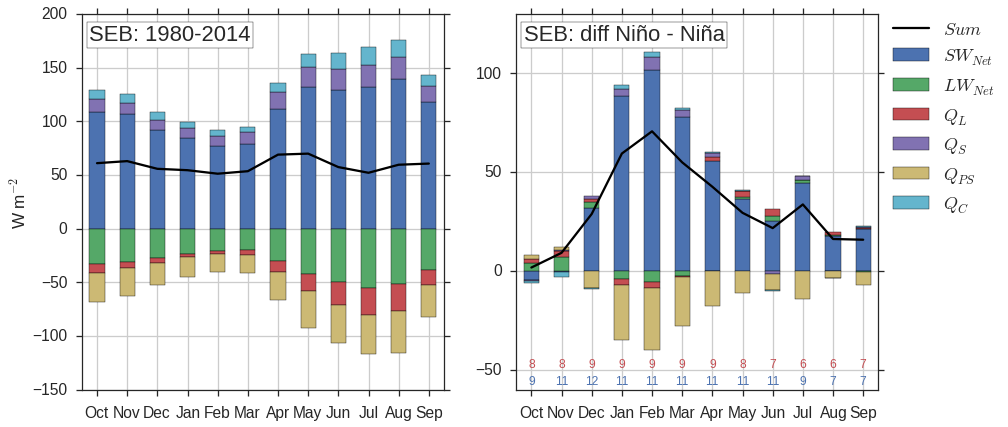

In [25]:
datal = dfea
datar = dfed
p = sns.set_palette("deep")
plot_bar_budget(datal, datar, 'SEB', 'W m$^{-2}$', ylim2=[-60, 130])
plt.savefig(os.path.join(utils.get_plot_dir(), 'Fig_07a.pdf'))

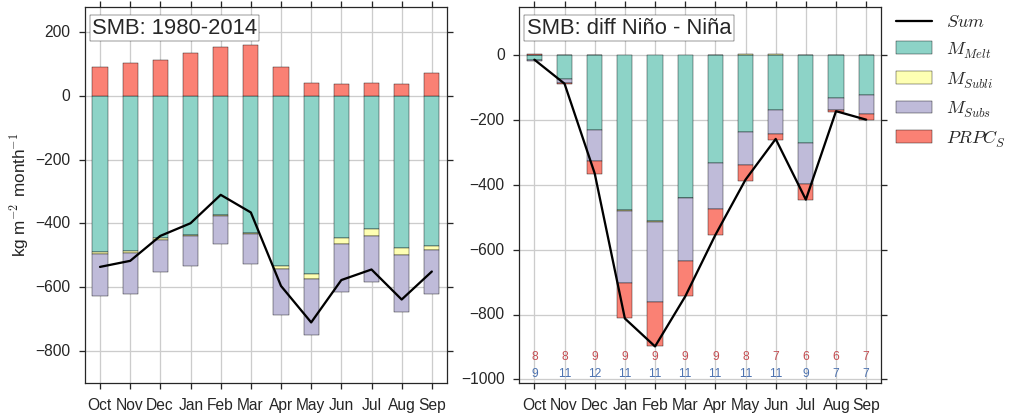

In [26]:
datal = dfma
datar = dfmd
sns.set_palette("Set3", 10)
plot_bar_budget(datal, datar, 'SMB', u'kg m$^{-2}$ month$^{-1}$', ylim1=[-900,280], ylim2=[-1010,150])
plt.savefig(os.path.join(utils.get_plot_dir(), 'Fig_07b.pdf'))

## Individual years (Fig 06)

In [28]:
def plot_ninonina_percycle(varn, ax, title='', unit='', ylim=None):
    
    alpha = 0.1
    alphal = 0.5
    
    v = neutdf['val ' + varn]['mean']
    v.plot(ax=ax, color='k', linewidth=2, label='Neutral')
        
    err = dfe[varn][0]
    gps = dft.groupby('sst is_nino')
    label = u'Niño'
    for i, g in gps:
        if not i: continue
        gys = g.groupby('sst yi')
        for y, gy in gys:
            v = gy['val ' + varn]
            ax.fill_between(gy['sst mi'], v.values-err, v.values+err, color=pal[2], interpolate=True, alpha=alpha)    
            ax.plot(gy['sst mi'], v, color=pal[2], linewidth=3, label=label, alpha=alphal)
            label = None
    
    gps = dft.groupby('sst is_nina')
    label = u'Niña'
    for i, g in gps:
        if not i: continue
        gys = g.groupby('sst yi')
        for y, gy in gys:
            v = gy['val ' + varn]
            ax.fill_between(gy['sst mi'], v.values-err, v.values+err, color=pal[0], interpolate=True, alpha=alpha)    
            ax.plot(gy['sst mi'], v, color=pal[0], linewidth=3, label=label, alpha=alphal)
            label = None
            
    ax.set_ylim(ylim)
    ax.set_xlabel('')
    ax.set_ylabel(unit)
    ax.set_xticks(np.arange(12)+1)
    _ = ax.set_xticklabels([m[0] for m in monthstr])
    
    plt.text(0.96, 0.90, title, transform=ax.transAxes, fontsize=20, ha='right',
         bbox=dict(facecolor='white', edgecolor='k', pad=10.0))

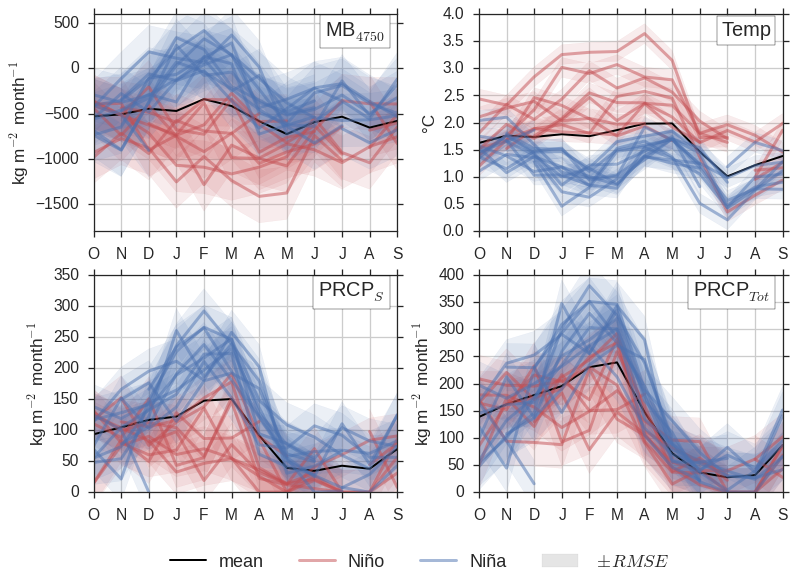

In [29]:
pal = sns.color_palette('deep')

fig = plt.figure(figsize=(11, 8), dpi=200)
ax = fig.add_subplot(221)
plot_ninonina_percycle('mbtotfromsum_diag', ax, unit=u'kg m$^{-2}$ month$^{-1}$', ylim=[-1800, 600], title='MB$_{4750}$ ')
ax = fig.add_subplot(222)
plot_ninonina_percycle('airtemp_ds', ax, unit=u'°C', title='Temp  ')
ax = fig.add_subplot(223)
plot_ninonina_percycle('prcpsolclip_diag', ax, unit=u'kg m$^{-2}$ month$^{-1}$', ylim=[0, 350], title='PRCP$_{S}$ ')
ax = fig.add_subplot(224)
plot_ninonina_percycle('prcptotclip_diag', ax, unit=u'kg m$^{-2}$ month$^{-1}$', ylim=[0, 400], title='PRCP$_{Tot}$ ')

handles, labels = ax.get_legend_handles_labels()

plt.tight_layout()
plt.subplots_adjust(left=0.11, right=0.98, top=0.98, bottom=0.15)

pat3 = mpatches.Patch(color='k', alpha=0.1, label='$\pm RMSE$')
plt.legend(handles=handles + [pat3], bbox_to_anchor=(0.65, -0.25),
           ncol=4, borderaxespad=0., frameon=False, fontsize=18);

plt.savefig(os.path.join(utils.get_plot_dir(), 'Fig_06.pdf'))